In [80]:
import sys
sys.path.append('../..')

import eeg_decoder
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io

np.random.seed(42)
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
OVERWRITE = False
np.random.seed(42)

In [3]:
experiment_name = 'e'
data_dir = f'./e/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])
eyefiles = sorted(list(exp.data_dir.glob('*eyetracking*.mat')))

In [56]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 1000

stim_off = 500  # ms

group_dict = OrderedDict([('SS1_col',[11]),('SS2_col',[12]), ('SS1_mot',[21]),('SS2_mot',[22])])

name_map = {10:'SS0 Color', 11:'SS1 Color', 12:'SS2 Color', 20:'SS0 Motion', 21:'SS1 Motion', 22:'SS2 Motion'}

In [57]:
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)
clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

In [65]:
mean_dists = defaultdict(list)
for isub in range(exp.nsub):

    print(isub)
    xdata_eeg,ydata = exp.load_eeg(isub)
    eyedata = io.loadmat(eyefiles[isub])['eyetracking']
    eyedata = np.rollaxis(eyedata, -1)  # reorder to trial, feat, time
    if isub!= 14:  # no correspondence between number of eye trials and number of eeg trials
        assert eyedata.shape[0] == ydata.shape[0]
        assert eyedata.shape[2] == xdata_eeg.shape[2]
        assert eyedata.shape[1] == 6 # 2 EOG, l-x, l-y, r-x, r-y
        eyedata = eyedata[:, 2:, :]  # drop EOGs

        # drop to just the delay period
        eyedata = eyedata[:,:, exp.info['times'] > stim_off]

        x_locs = eyedata[:, ::2, :].mean(1)
        y_locs = eyedata[:, 1::2, :].mean(1)

        # get average distance from fixation over time
        dists = np.sqrt(x_locs**2 + y_locs**2)

        # see how much the eyes moved, on average
        x_diffs = np.diff(x_locs, 1)  # get differences across time
        y_diffs = np.diff(y_locs, 1)

        euclid_diffs = np.sqrt(x_diffs**2 + y_diffs**2)  # get euclidean distance between timepoints
        euclid_diffs = euclid_diffs.sum(1)  # sum over time


        mean_dists['Sub'] = np.concatenate([mean_dists['Sub'], [isub] * dists.shape[0]])
        mean_dists['Mean Dist'] = np.concatenate([mean_dists['Mean Dist'], dists.mean(1)])
        mean_dists['Condition'] = np.concatenate([mean_dists['Condition'], ydata])
        mean_dists['X Loc'] = np.concatenate([mean_dists['X Loc'], x_locs.mean(1)])
        mean_dists['Y Loc'] = np.concatenate([mean_dists['Y Loc'], y_locs.mean(1)])
        mean_dists['Distance Traveled'] = np.concatenate([mean_dists['Distance Traveled'], euclid_diffs])

dist_df = pd.DataFrame(mean_dists)
dist_df['Condition'] = dist_df['Condition'].map(name_map)  # get readable condition names
dist_df = dist_df[~dist_df['Condition'].isin(['SS0 Color', 'SS0 Motion'])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


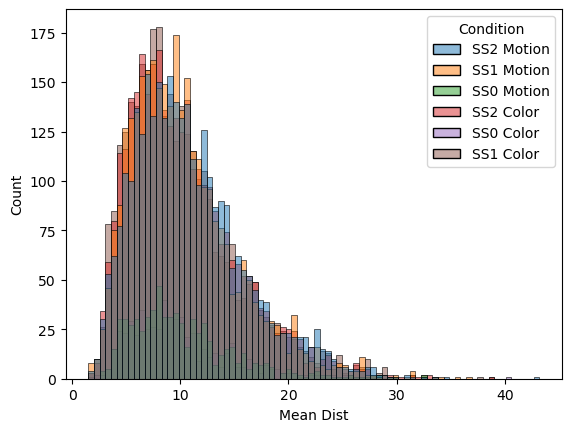

In [61]:
_ = sns.histplot(data=dist_df, x='Mean Dist', hue='Condition')

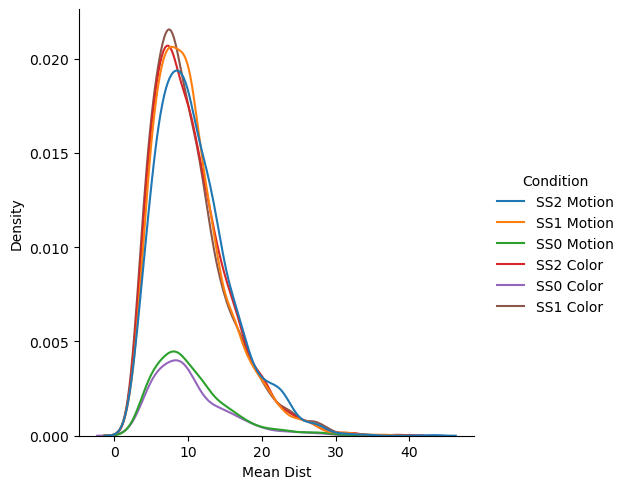

In [62]:
_ = sns.displot(data=dist_df, x='Mean Dist', hue='Condition', kind='kde')

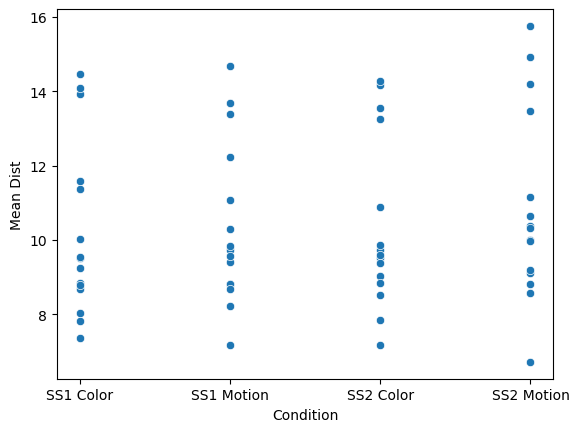

In [66]:
mean_dist_df = dist_df.groupby(['Sub', 'Condition']).mean().reset_index()
_ = sns.scatterplot(data=mean_dist_df, x='Condition', y='Mean Dist')

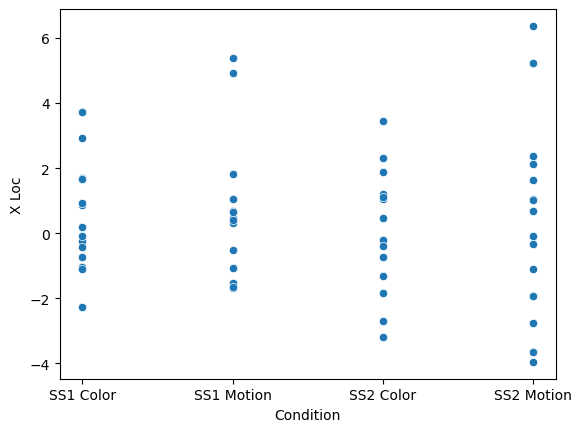

In [67]:
_ = sns.scatterplot(data=mean_dist_df, x='Condition', y='X Loc')

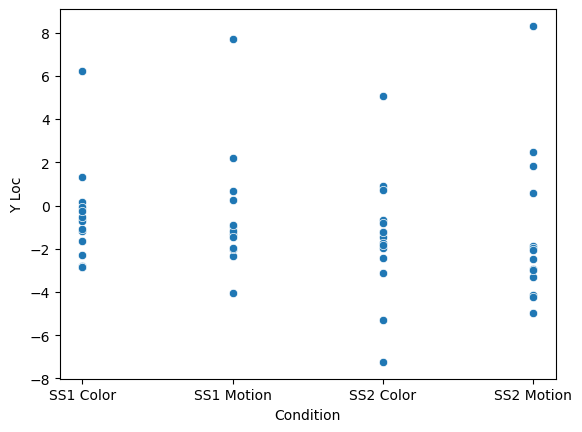

In [68]:
_ = sns.scatterplot(data=mean_dist_df, x='Condition', y='Y Loc')

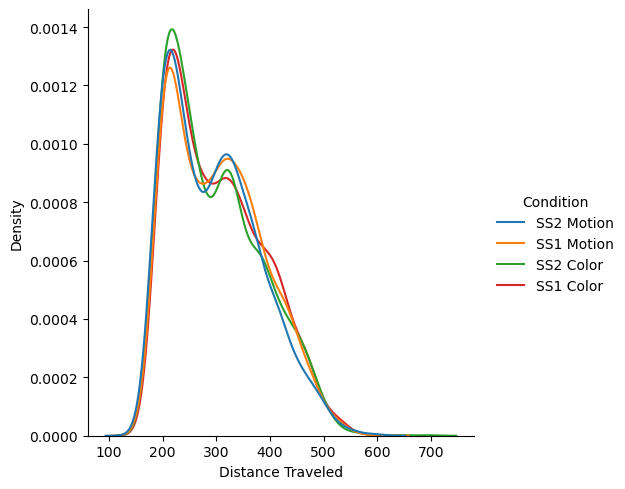

In [69]:
_ = sns.displot(data=dist_df, x='Distance Traveled', hue='Condition', kind='kde')

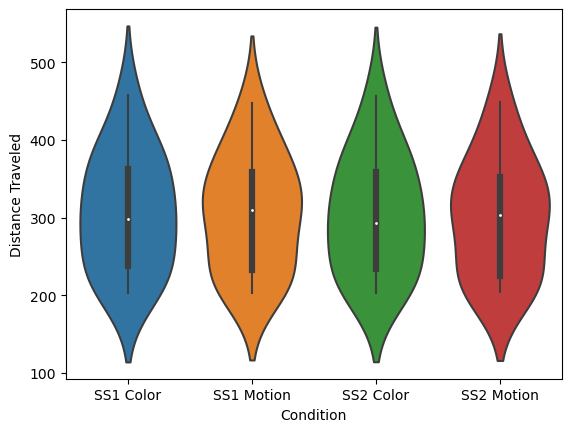

In [70]:
_ = sns.violinplot(data=mean_dist_df, x='Condition', y='Distance Traveled')

In [71]:
dist_df['Set Size'] = np.where(dist_df['Condition'].str.contains('SS1'), 1, 2)
dist_df['Attended Feature'] = np.where(dist_df['Condition'].str.contains('Color'), 'Color', 'Motion')
dist_df

,Sub,Mean Dist,Condition,X Loc,Y Loc,Distance Traveled,Set Size,Attended Feature
0,0.0,10.799212,SS2 Motion,9.569514,4.644388,181.911270,2,Motion
1,0.0,7.016842,SS1 Motion,1.376811,-6.273773,167.726288,1,Motion
2,0.0,3.328474,SS1 Motion,1.168805,-2.015701,177.525833,1,Motion
3,0.0,3.472920,SS1 Motion,1.003199,-1.490220,192.798355,1,Motion
4,0.0,3.146400,SS2 Motion,-0.042830,2.323127,156.489914,2,Motion
...,...,...,...,...,...,...,...,...
14056,15.0,20.610769,SS2 Color,16.913502,11.265417,244.166351,2,Color
14057,15.0,5.663168,SS1 Color,-0.847358,4.414793,238.034439,1,Color
14059,15.0,10.995822,SS2 Color,5.644952,-9.217108,248.059540,2,Color
14060,15.0,20.094118,SS2 Color,-19.624569,-1.415735,244.112244,2,Color


In [81]:
dist_df.groupby(['Sub', 'Set Size', 'Attended Feature', 'Condition']).mean().reset_index()

,Sub,Set Size,Attended Feature,Condition,Mean Dist,X Loc,Y Loc,Distance Traveled
0,0.0,1,Color,SS1 Color,7.366517,-0.226031,1.311861,230.751776
1,0.0,1,Motion,SS1 Motion,7.173063,0.459234,0.237385,223.007188
2,0.0,2,Color,SS2 Color,7.164350,-0.215227,0.886824,227.207941
3,0.0,2,Motion,SS2 Motion,6.713939,-0.077645,0.564052,212.222764
4,1.0,1,Color,SS1 Color,8.843533,-0.088523,-2.790062,211.971504
5,1.0,1,Motion,SS1 Motion,9.734626,1.040279,0.675748,217.290113
6,1.0,2,Color,SS2 Color,8.502808,1.132911,-0.681407,207.641220
7,1.0,2,Motion,SS2 Motion,10.004139,1.635636,2.454250,217.130788
8,2.0,1,Color,SS1 Color,9.238903,0.867632,0.152147,398.801373
9,2.0,1,Motion,SS1 Motion,9.396946,0.669801,2.182622,402.299599


In [78]:
palette = {
'SS1 Color': 'gold',
'SS2 Color': 'darkorange',
'SS1 Motion': 'lightgreen',
'SS2 Motion': 'darkgreen',
}

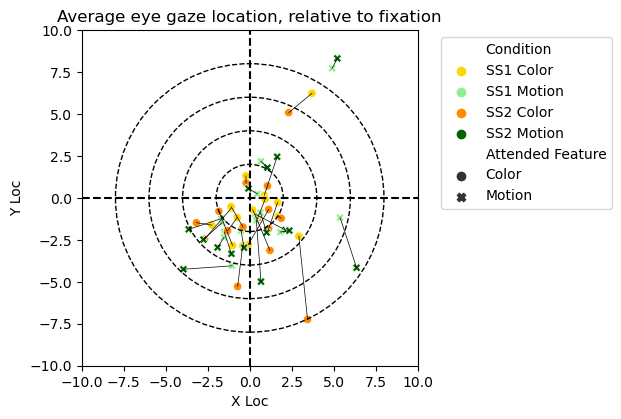

In [86]:
average_df = dist_df.groupby(['Sub', 'Set Size', 'Attended Feature', 'Condition']).mean().reset_index()
ax = sns.scatterplot(average_df,hue='Condition', x='X Loc', y='Y Loc', style='Attended Feature', palette= palette)
# add a line connecting SS1 and SS2 for each subject, within a given attended feature
plt.xlim(-10, 10)
plt.ylim(-10, 10)
for isub in average_df['Sub'].unique():
    for att_feat in average_df['Attended Feature'].unique():
        ss1 = average_df[(average_df['Sub'] == isub) & (average_df['Set Size'] == 1) & (average_df['Attended Feature'] == att_feat)]
        ss2 = average_df[(average_df['Sub'] == isub) & (average_df['Set Size'] == 2) & (average_df['Attended Feature'] == att_feat)]
        plt.plot([ss1['X Loc'].values[0], ss2['X Loc'].values[0]], [ss1['Y Loc'].values[0], ss2['Y Loc'].values[0]], color='black', linewidth=0.5)

# move legend outside of plot
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# add horizonal and vertical lines going through the origin
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# add dashed circles at 2 degrees, 4 degrees, and 6 degrees
for radius in [2, 4, 6, 8]:
    circle = plt.Circle((0, 0), radius, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

_ = plt.title('Average eye gaze location, relative to fixation')
plt.tight_layout()
ax.set_aspect('equal', adjustable='box')
plt.savefig('figures/eye_gaze_location.svg', format='svg')

In [ ]:
import pingouin as pg

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Set Size,1.624699,1,14,1.624699,5.093393,0.040526,0.040526,0.005163,1.0
1,Attended Feature,1.620398,1,14,1.620398,3.932344,0.067338,0.067338,0.005150,1.0
2,Set Size * Attended Feature,0.467264,1,14,0.467264,2.701855,0.122492,0.122492,0.001490,1.0


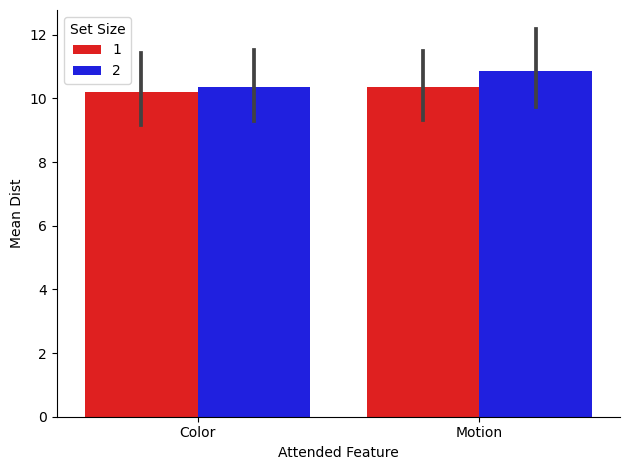

In [87]:
_ = sns.barplot(average_df, x='Attended Feature', y='Mean Dist', hue='Set Size', palette={1:'red', 2:'blue'})
sns.despine()
plt.tight_layout()
plt.savefig('figures/eye_gaze_anova_totalDist.svg', format='svg')


pg.rm_anova(data=dist_df, dv='Mean Dist', within=['Set Size', 'Attended Feature'], subject='Sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Set Size,0.228485,1,14,0.228485,0.362633,0.556676,0.556676,0.000832,1.0
1,Attended Feature,0.833637,1,14,0.833637,0.654171,0.432156,0.432156,0.003029,1.0
2,Set Size * Attended Feature,0.051006,1,14,0.051006,0.125148,0.728788,0.728788,0.000186,1.0


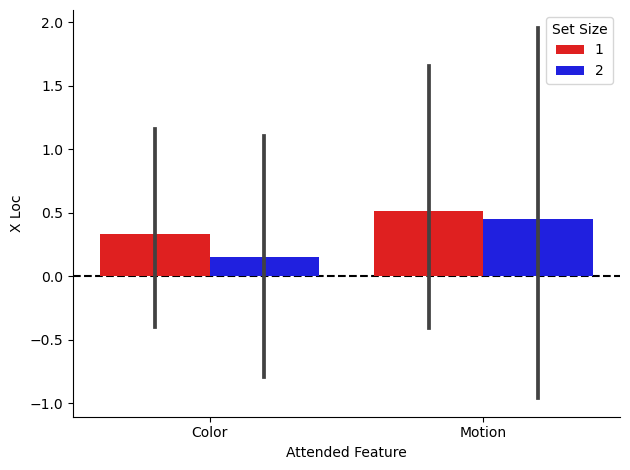

In [88]:
# repeat but looking at X pos and Y pos separately

# X pos
_ = sns.barplot(average_df, x='Attended Feature', y='X Loc', hue='Set Size', palette={1:'red', 2:'blue'})
plt.axhline(0, color='black', linestyle='--', zorder=0)
sns.despine()
plt.tight_layout()
plt.savefig('figures/eye_gaze_anova_Xloc.svg', format='svg')

pg.rm_anova(data=dist_df, dv='X Loc', within=['Set Size', 'Attended Feature'], subject='Sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Set Size,9.871448,1,14,9.871448,4.802915,0.045819,0.045819,0.021830,1.0
1,Attended Feature,0.155898,1,14,0.155898,0.071416,0.793183,0.793183,0.000352,1.0
2,Set Size * Attended Feature,0.070410,1,14,0.070410,0.172404,0.684278,0.684278,0.000159,1.0


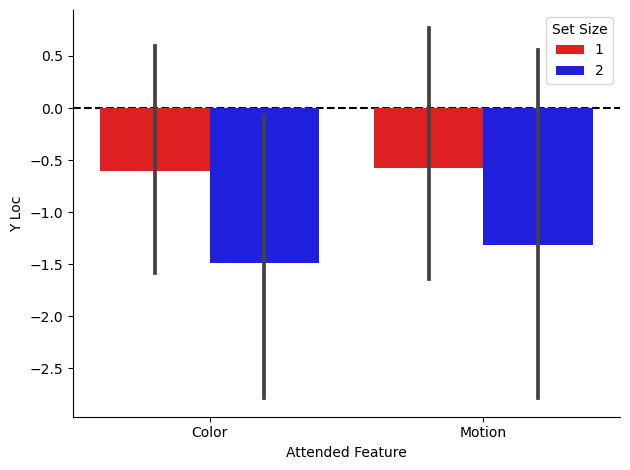

In [89]:
# Y pos
_ = sns.barplot(average_df, x='Attended Feature', y='Y Loc', hue='Set Size', palette={1:'red', 2:'blue'})
sns.despine()
plt.axhline(0, color='black', linestyle='--', zorder=0)
plt.tight_layout()
plt.savefig('figures/eye_gaze_anova_Yloc.svg', format='svg')

pg.rm_anova(data=dist_df, dv='Y Loc', within=['Set Size', 'Attended Feature'], subject='Sub')